The dataset coming from CIC-UNSW contains network flow features with various attack types :
- CICFlowMeter_out.csv: Contains network flow features (447,916 records)
- Label.csv: Numeric labels corresponding to attack types
- README.txt: Maps numeric labels to attack types (0=Benign, 3=DoS, 4=Exploits, etc.)

# Step 1: Environment Setup
First, let's set up our Python environment with the necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import time

In [5]:
DATASETS = './datasets/CIC-IDS/CICFlowMeter_out.csv'
DATAS = './datasets/CIC-IDS/Data.csv'
LABELS = './datasets/CIC-IDS/Label.csv'

# Step 3: Data Loading and Preprocessing
Let's create a function to load and preprocess the dataset:

In [7]:
def load_and_preprocess_data():
    """Load and preprocess the network traffic data"""
    print("Loading dataset...")
    
    # Load feature data from CICFlowMeter output
    data = pd.read_csv(DATASETS)
    
    # Load labels
    labels = pd.read_csv(LABELS)
    
    # Load label mapping from README
    label_mapping = {
        0: "Benign",
        1: "Analysis",
        2: "Backdoor",
        3: "DoS",
        4: "Exploits",
        5: "Fuzzers",
        6: "Generic",
        7: "Reconnaissance",
        8: "Shellcode",
        9: "Worms"
    }
    
    print(f"Loaded dataset with {len(data)} records")
    
    # Drop non-feature columns
    drop_cols = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp']
    features = data.drop(drop_cols, axis=1, errors='ignore')
    
    # Handle missing values and infinities
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.dropna()
    
    # Extract labels from the 'Label' column
    if 'Label' in features.columns:
        # If labels are embedded in the dataset
        y = features['Label'].copy()
        X = features.drop('Label', axis=1)
    else:
        # If labels are in a separate file
        X = features
        y = labels['Label'][:len(features)]  # Align lengths
    
    print(f"Preprocessed data shape: {X.shape}")
    
    return X, y, label_mapping

# Step 4: Building the Intrusion Detection System Class
Let's create a class to encapsulate our IDS functionality:

In [ ]:
class IntrusionDetectionSystem:
    """Network Intrusion Detection System using Machine Learning"""
    
    def __init__(self, model=None, scaler=None, label_mapping=None):
        self.model = model
        self.scaler = scaler
        self.label_mapping = label_mapping
        self.feature_names = None
    
    def train(self, X, y, test_size=0.25):
        """Train the IDS model"""
        print("Training IDS model...")
        
        # Save feature names if X is a DataFrame
        self.feature_names = X.columns.tolist() if isinstance(X, pd.DataFrame) else None
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train Random Forest model
        start_time = time.time()
        print("Training Random Forest classifier...")
        self.model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        self.model.fit(X_train_scaled, y_train)
        training_time = time.time() - start_time
        print(f"Model trained in {training_time:.2f} seconds")
        
        # Evaluate model
        y_pred = self.model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model accuracy: {accuracy:.4f}")
        
        return X_test_scaled, y_test, y_pred
    
    def create_better_label_mapping():
        # Create bidirectional mapping from README.txt
        id_to_name = {}
        name_to_id = {}
        
        with open("README.txt", 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2 and parts[-1].isdigit():
                    label_name = ' '.join(parts[:-1]).strip()
                    label_value = int(parts[-1])
                    id_to_name[label_value] = label_name
                    name_to_id[label_name] = label_value
        
        return id_to_name, name_to_id   
    
    def evaluate(self, X_test, y_test, y_pred=None):
        """Evaluate model performance with detailed metrics"""
        if y_pred is None:
            X_test_scaled = self.scaler.transform(X_test)
            y_pred = self.model.predict(X_test_scaled)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Generate classification report without using target_names to avoid mapping errors
        report = classification_report(y_test, y_pred)
        
        print(f"Model accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        cm = confusion_matrix(y_test, y_pred)
        
        # Create a simple heatmap without custom labels
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        return accuracy, report
    
    def visualize_feature_importance(self, top_n=20):
        """Visualize the most important features for detection"""
        if not self.model or not hasattr(self.model, 'feature_importances_'):
            print("Model doesn't support feature importance visualization")
            return None
            
        # Get feature importance
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Use stored feature names or generate generic ones
        features = self.feature_names if self.feature_names else [f"Feature_{i}" for i in range(len(importances))]
        
        # Plot top N features
        plt.figure(figsize=(12, 8))
        plt.title(f"Top {top_n} Feature Importances")
        plt.bar(range(top_n), importances[indices[:top_n]])
        plt.xticks(range(top_n), [features[i] for i in indices[:top_n]], rotation=90)
        plt.tight_layout()
        plt.show()
        
        # Return DataFrame of feature importances
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        return importance_df.head(top_n)
    
    def detect_intrusion(self, network_data, threshold=0.5):
        """
        Detect intrusions in network data
        
        Args:
            network_data: DataFrame or numpy array of network flow features
            threshold: Confidence threshold for alerts
            
        Returns:
            DataFrame with detection results
        """
        if not self.model:
            print("Model not trained. Train the model first.")
            return None
        
        # Handle different input types
        if isinstance(network_data, np.ndarray):
            # NumPy array - already preprocessed
            data_scaled = network_data
        else:
            # Pandas DataFrame - needs preprocessing
            data = network_data.copy()
            #data = data.replace([np.inf, -np.inf], np.nan).dropna()
            data_scaled = self.scaler.transform(data)
        
        # Make predictions
        predictions = self.model.predict(data_scaled)
        
        # Get prediction probabilities if the model supports it
        if hasattr(self.model, 'predict_proba'):
            probabilities = self.model.predict_proba(data_scaled)
            confidence = np.max(probabilities, axis=1)
        else:
            # Default confidence if probabilities aren't available
            confidence = np.ones(len(predictions)) * 0.8
        
        # Create results DataFrame
        results = pd.DataFrame({
            'Prediction': predictions,
            'Confidence': confidence
        })
        
        # Add attack type if label mapping exists
        if self.label_mapping:
            results['AttackType'] = results['Prediction'].map(
                lambda x: self.label_mapping.get(x, f"Unknown ({x})")
            )
        
        # Add alert flag (True if not benign and confidence > threshold)
        results['Alert'] = (results['Prediction'] != 0) & (results['Confidence'] > threshold)
        
        return results
    
    def save_model(self, filepath='ids_model.joblib'):
        """Save the trained model to disk"""
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'label_mapping': self.label_mapping,
            'feature_names': self.feature_names
        }
        
        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")
    
    @classmethod
    def load_model(cls, filepath='ids_model.joblib'):
        """Load a trained model from disk"""
        model_data = joblib.load(filepath)
        
        ids = cls(
            model=model_data['model'],
            scaler=model_data['scaler'],
            label_mapping=model_data['label_mapping']
        )
        ids.feature_names = model_data['feature_names']
        
        print(f"Model loaded from {filepath}")
        return ids

### Explication du **Random Forest Classifier** en français

Le **Random Forest Classifier** est un algorithme d'apprentissage supervisé utilisé pour des tâches de classification et de régression. Il repose sur le concept d'**apprentissage par ensemble** (*ensemble learning*), qui combine les prédictions de plusieurs modèles (dans ce cas, des arbres de décision) pour améliorer la précision et réduire le risque de surapprentissage (*overfitting*).

---

### Comment fonctionne le Random Forest ?

1. **Arbres de décision** :
   - Une forêt aléatoire est composée de plusieurs **arbres de décision**.
   - Chaque arbre est entraîné sur un sous-ensemble aléatoire des données d'entraînement (technique appelée **bootstrap sampling**).
   - Lors de chaque division dans un arbre, un sous-ensemble aléatoire des caractéristiques est sélectionné pour déterminer la meilleure division (cette technique est appelée **feature bagging**).

2. **Ensemble Learning** :
   - Les prédictions de tous les arbres sont combinées pour produire une prédiction finale.
   - Pour les tâches de classification, la classe finale est déterminée par un **vote majoritaire** : la classe qui reçoit le plus de votes parmi les arbres est choisie.
   - Pour les tâches de régression, la prédiction finale est la **moyenne** des prédictions de tous les arbres.

3. **Aléatoire** :
   - L'aléatoire dans la sélection des données et des caractéristiques garantit que les arbres sont diversifiés et non corrélés, ce qui réduit le risque de surapprentissage.

---


### Paramètres importants du Random Forest

1. **`n_estimators`** :
   - Nombre d'arbres dans la forêt.
   - Augmenter cette valeur améliore généralement les performances, mais augmente le coût computationnel.

2. **`max_depth`** :
   - Profondeur maximale de chaque arbre.
   - Limiter la profondeur peut éviter le surapprentissage.

3. **`max_features`** :
   - Nombre de caractéristiques à considérer pour chaque division.
   - Valeurs courantes :
     - `"sqrt"` : Racine carrée du nombre total de caractéristiques (par défaut pour la classification).
     - `"log2"` : Logarithme (base 2) du nombre total de caractéristiques.
     - Une valeur entière spécifique.

4. **`min_samples_split`** :
   - Nombre minimum d'échantillons requis pour diviser un nœud interne.

5. **`min_samples_leaf`** :
   - Nombre minimum d'échantillons requis pour être dans une feuille.

6. **`bootstrap`** :
   - Indique si l'échantillonnage bootstrap est utilisé (par défaut `True`).

# Step 5: Main Execution Function
Let's create the main function to orchestrate the IDS pipeline:

In [25]:
def main():
    """Main function to build and test the IDS"""
    # Step 1: Load and preprocess data
    X, y, label_mapping = load_and_preprocess_data()
    
    # Step 2: Create and train IDS
    ids = IntrusionDetectionSystem(label_mapping=label_mapping)
    X_test, y_test, y_pred = ids.train(X, y)
    
    # Step 3: Evaluate model performance
    ids.evaluate(X_test, y_test, y_pred)
    
    # Step 4: Visualize feature importance
    top_features = ids.visualize_feature_importance(top_n=15)
    print("\nTop 15 Most Important Features:")
    print(top_features)
    
    # Step 5: Save the model
    ids.save_model('ids_model.joblib')
    
    return ids, X_test

Loading dataset...
Loaded dataset with 3540241 records
Preprocessed data shape: (3540241, 76)
Training IDS model...
Training Random Forest classifier...
Model trained in 536.93 seconds
Model accuracy: 0.9853
Model accuracy: 0.9853

Classification Report:
                precision    recall  f1-score   support

      Analysis       0.33      0.02      0.04        96
      Backdoor       0.83      0.42      0.56       104
        Benign       0.99      1.00      0.99    862603
           DoS       0.66      0.28      0.39      1153
      Exploits       0.76      0.74      0.75      7796
       Fuzzers       0.53      0.37      0.44      7378
       Generic       0.80      0.73      0.76      1139
Reconnaissance       0.79      0.64      0.71      4210
     Shellcode       0.42      0.24      0.31       515
         Worms       0.59      0.28      0.38        67

      accuracy                           0.99    885061
     macro avg       0.67      0.47      0.53    885061
  weighted avg 

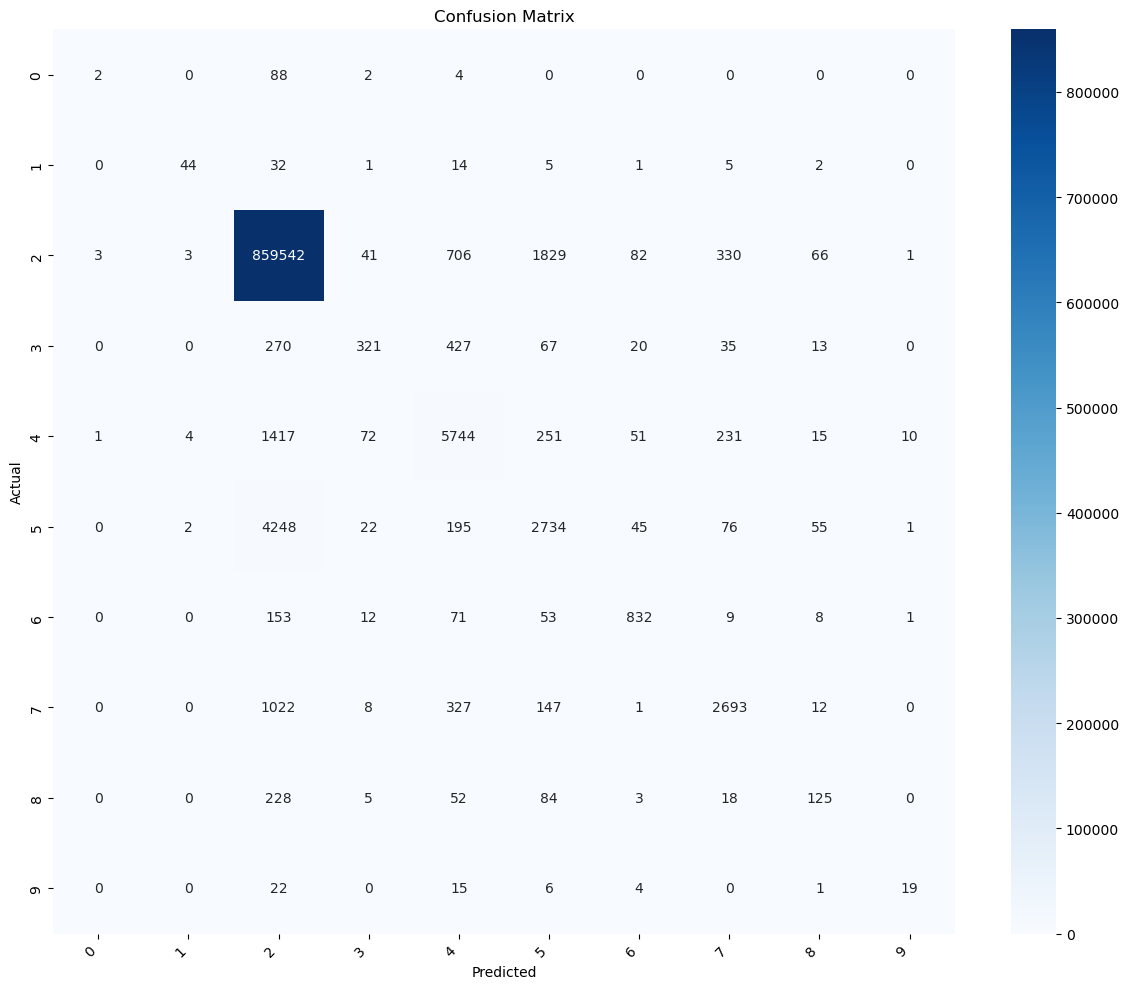

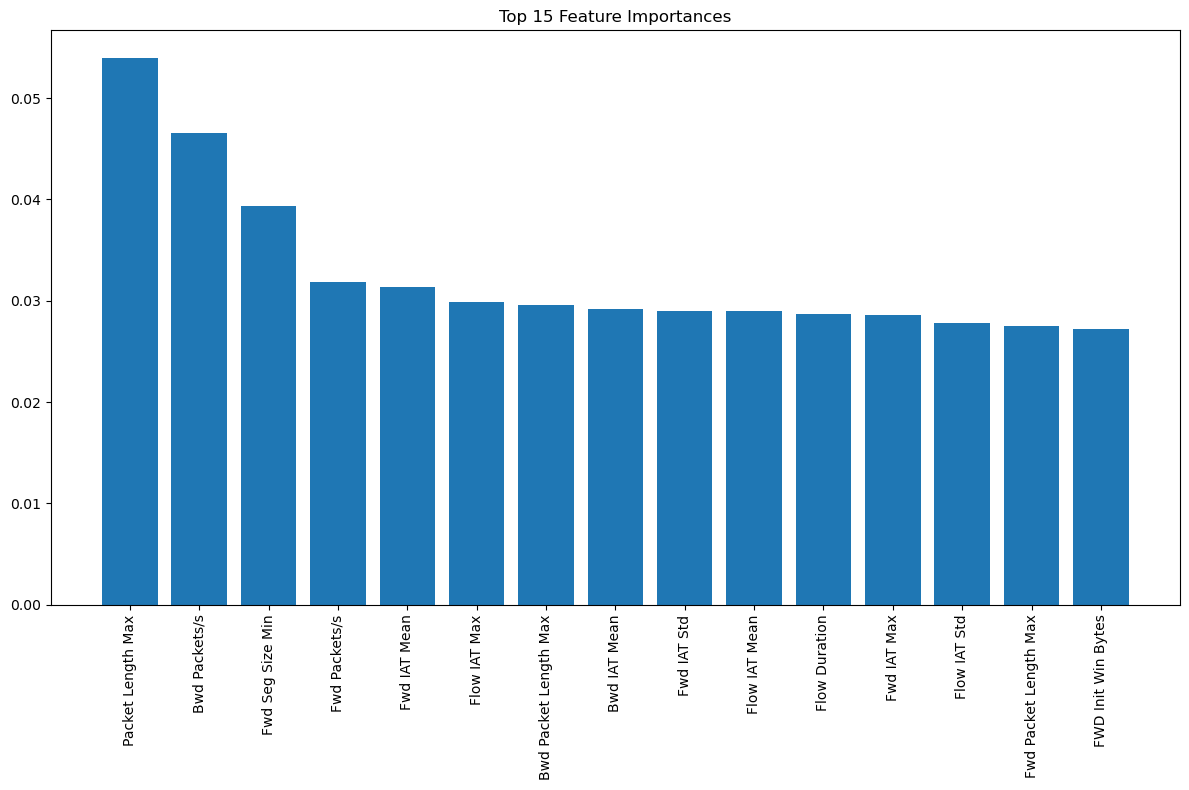


Top 15 Most Important Features:
                  Feature  Importance
38      Packet Length Max    0.053992
36          Bwd Packets/s    0.046572
67       Fwd Seg Size Min    0.039373
35          Fwd Packets/s    0.031826
20           Fwd IAT Mean    0.031334
17           Flow IAT Max    0.029854
9   Bwd Packet Length Max    0.029595
25           Bwd IAT Mean    0.029183
21            Fwd IAT Std    0.028954
15          Flow IAT Mean    0.028952
0           Flow Duration    0.028648
22            Fwd IAT Max    0.028597
16           Flow IAT Std    0.027828
5   Fwd Packet Length Max    0.027502
64     FWD Init Win Bytes    0.027250
Model saved to ids_model.joblib


In [26]:
ids, X_test = main()

In [27]:
# Step 6: Test real-time detection
print("\nSimulating real-time detection...")

# Get a small sample of test data
sample_size = min(10, len(X_test))
sample_data = X_test[:sample_size]

# Process the sample data
start_time = time.time()
results = ids.detect_intrusion(sample_data)
end_time = time.time()

# Print results
print(f"\nProcessed {sample_size} flows in {end_time - start_time:.4f} seconds")
print(f"Average processing time: {(end_time - start_time) / sample_size * 1000:.2f} ms per flow")
print("\nDetection Results:")
print(results)

# Count alerts
alert_count = results['Alert'].sum()
print(f"\nDetected {alert_count} potential attacks out of {sample_size} flows")


Simulating real-time detection...

Processed 10 flows in 0.1458 seconds
Average processing time: 14.58 ms per flow

Detection Results:
  Prediction  Confidence        AttackType  Alert
0     Benign        1.00  Unknown (Benign)   True
1     Benign        1.00  Unknown (Benign)   True
2     Benign        0.96  Unknown (Benign)   True
3     Benign        1.00  Unknown (Benign)   True
4     Benign        1.00  Unknown (Benign)   True
5     Benign        1.00  Unknown (Benign)   True
6     Benign        1.00  Unknown (Benign)   True
7     Benign        1.00  Unknown (Benign)   True
8     Benign        1.00  Unknown (Benign)   True
9     Benign        1.00  Unknown (Benign)   True

Detected 10 potential attacks out of 10 flows


In [ ]:
import pandas as pd
import numpy as np
import joblib
import random
import time

class AttackSimulator:
    """Simulate attacks and evaluate them using a trained ML model."""
    
    def __init__(self, model_path='ids_model.joblib', label_mapping=None):
        """Initialize the simulator with the trained model."""
        print("Loading ML model...")
        model_data = joblib.load(model_path)
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.label_mapping = label_mapping or model_data.get('label_mapping', {})
        self.feature_names = model_data.get('feature_names', None)
        print("Model loaded successfully!")
    
    def simulate_attack(self, dataset_path, attack_label, num_samples=5):
        """
        Simulate an attack by selecting samples from the dataset with the given attack label.
        
        Args:
            dataset_path (str): Path to the dataset (CSV file).
            attack_label (int): Numeric label of the attack to simulate.
            num_samples (int): Number of attack samples to simulate.
        
        Returns:
            pd.DataFrame: Simulated attack data.
        """
        print(f"Simulating {num_samples} attack samples for label: {attack_label}...")
        
        # Load the dataset
        data = pd.read_csv(dataset_path)
        
        # Filter rows with the specified attack label
        attack_data = data[data['Label'] == attack_label]
        
        if attack_data.empty:
            print(f"No data found for attack label: {attack_label}")
            return None
        
        # Randomly sample attack data
        simulated_data = attack_data.sample(n=min(num_samples, len(attack_data)), random_state=42)
        print(f"Simulated {len(simulated_data)} attack samples.")
        
        return simulated_data
    
    def evaluate_attack(self, attack_data):
        """
        Evaluate the simulated attack data using the trained ML model.
        
        Args:
            attack_data (pd.DataFrame): Simulated attack data.
        
        Returns:
            pd.DataFrame: Results with predictions and confidence scores.
        """
        if attack_data is None or attack_data.empty:
            print("No attack data to evaluate.")
            return None
        
        print("Evaluating attack data...")
        
        # Drop identifier columns and the label column
        drop_cols = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Label']
        features = attack_data.drop([col for col in drop_cols if col in attack_data.columns], axis=1)
        
        # Handle missing values and infinities
        features = features.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        # Scale the features
        features_scaled = self.scaler.transform(features)
        
        # Make predictions
        predictions = self.model.predict(features_scaled)
        probabilities = self.model.predict_proba(features_scaled)
        
        # Add predictions and confidence scores to the attack data
        attack_data['Prediction'] = predictions
        attack_data['Confidence'] = np.max(probabilities, axis=1)
        attack_data['AttackType'] = attack_data['Prediction'].map(
            lambda x: self.label_mapping.get(x, f"Unknown ({x})")
        )
        
        return attack_data
    
    def display_results(self, results):
        """
        Display the results of the attack evaluation.
        
        Args:
            results (pd.DataFrame): Results with predictions and confidence scores.
        """
        if results is None or results.empty:
            print("No results to display.")
            return
        
        print("\nAttack Simulation Results:")
        print(results[['Prediction', 'AttackType', 'Confidence']])
        
        # Count the number of detected attacks
        detected_attacks = results[results['Prediction'] != 0]
        print(f"\nDetected {len(detected_attacks)} attacks out of {len(results)} samples.")
        
        # Display detailed results
        for _, row in detected_attacks.iterrows():
            print(f"Detected {row['AttackType']} attack with confidence {row['Confidence']:.2f}")
    
    def run_simulation(self, dataset_path, attack_label, num_samples=5):
        """
        Run the full attack simulation and evaluation pipeline.
        
        Args:
            dataset_path (str): Path to the dataset (CSV file).
            attack_label (int): Numeric label of the attack to simulate.
            num_samples (int): Number of attack samples to simulate.
        """
        # Step 1: Simulate attack
        attack_data = self.simulate_attack(dataset_path, attack_label, num_samples)
        
        # Step 2: Evaluate attack
        results = self.evaluate_attack(attack_data)
        
        # Step 3: Display results
        self.display_results(results)


if __name__ == "__main__":
    # Path to your dataset and trained model
    dataset_path = DATASETS
    model_path = "ids_model.joblib"       # Replace with the path to your trained model
    
    # Label mapping from README.txt
    label_mapping = {
        0: "Benign",
        1: "Analysis",
        2: "Backdoor",
        3: "DoS",
        4: "Exploits",
        5: "Fuzzers",
        6: "Generic",
        7: "Reconnaissance",
        8: "Shellcode",
        9: "Worms"
    }
    
    # Initialize the simulator
    simulator = AttackSimulator(model_path=model_path, label_mapping=label_mapping)
    
    # Simulate and evaluate an attack
    attack_label = 1  # Example: DoS attack
    num_samples = 10  # Number of attack samples to simulate
    simulator.run_simulation(dataset_path, attack_label, num_samples)

Loading ML model...
Model loaded successfully!
Simulating 10 attack samples for label: 1...
No data found for attack label: 1
No attack data to evaluate.
No results to display.


# Now with FinBert model.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import fastparquet
warnings.filterwarnings('ignore')

c:\Users\Desktop\Desktop\AI-IDS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:

class LocalCSVDataLoader:
    """Load and process CSV files from local project directory"""
    
    def __init__(self, data_dir='data'):
        self.data_dir = data_dir
    
    
    def analyze_dataset(self, df):
        """Analyze the loaded dataset structure"""
        print("\n📈 Dataset Analysis:")
        print(f"Shape: {df.shape}")
        print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
        # Check for label columns
        potential_label_cols = ['label', 'Label', 'attack', 'Attack', 'class', 'Class', 
                               'attack_type', 'Attack_Type', 'category', 'Category']
        
        label_col = None
        for col in potential_label_cols:
            if col in df.columns:
                label_col = col
                break
        
        if label_col:
            print(f"📋 Found label column: '{label_col}'")
            print("Attack distribution:")
            print(df[label_col].value_counts().head(10))
        else:
            print("⚠️  No obvious label column found")
            print("Available columns:")
            for i, col in enumerate(df.columns):
                print(f"  {i}: {col}")
        
        return label_col


In [ ]:

class NetworkTrafficDataset(Dataset):
    """Dataset for network traffic classification"""
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:

class NetworkIDSClassifier:
    """Network IDS Classifier for local CSV files"""
    
    def __init__(self):
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = None
        self.class_names = [
            "Benign", "Analysis", "Backdoor", "DoS", "Exploits",
            "Fuzzers", "Generic", "Reconnaissance", "Shellcode", "Worms"
        ]
        self.loader = LocalCSVDataLoader()
        
    def load_and_prepare_data(self):
        """Load data from local CSV files"""
        print("📥 Loading data from local CSV files...")
        DATASET = 'C:/Users/Desktop/Desktop/AI-IDS/datasets/KaggleCSECICDatasetLoader/NF-CSE-CIC-IDS2018-V2.parquet'
        # Find CSV files
        # csv_files = pd.read_csv(DATASET, low_memory=False)
        df = pd.read_parquet(DATASET, engine='fastparquet')
        
        # Load CSV files
        if df is None:
            raise ValueError("Failed to load any CSV files")
        
        # Analyze dataset
        label_col = self.loader.analyze_dataset(df)
        
        return df, label_col
    
    def preprocess_data(self, df, label_col=None):
        """Preprocess the dataset for text classification"""
        print("🔧 Preprocessing data...")
        
        # Handle missing values
        df = df.fillna(0)
        
        # Auto-detect label column if not provided
        if label_col is None:
            potential_cols = ['label', 'Label', 'attack', 'Attack', 'class', 'Class']
            for col in potential_cols:
                if col in df.columns:
                    label_col = col
                    break
        
        if label_col is None:
            print("❌ No label column found. Please specify the label column name.")
            print("Available columns:", list(df.columns))
            return None
        
        def create_network_text(row):
            """Create text representation from network features"""
            text_parts = []
            
            # Get numeric columns (excluding label column)
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            numeric_cols = [col for col in numeric_cols if col != label_col]
            
            # Protocol and service information
            for col in ['protocol', 'Protocol', 'proto', 'service', 'Service']:
                if col in df.columns:
                    text_parts.append(f"{col.lower()} {row.get(col, 'unknown')}")
            
            # Port information
            for col in ['dst_port', 'dstport', 'destination_port', 'port']:
                if col in df.columns:
                    port = row.get(col, 0)
                    if port == 80:
                        text_parts.append("service http")
                    elif port == 443:
                        text_parts.append("service https")
                    elif port == 22:
                        text_parts.append("service ssh")
                    elif port == 21:
                        text_parts.append("service ftp")
                    else:
                        text_parts.append(f"port {port}")
            
            # Duration and timing
            for col in ['duration', 'Duration', 'flow_duration']:
                if col in df.columns:
                    duration = row.get(col, 0)
                    if duration > 10:
                        text_parts.append(f"long_duration {duration}")
                    elif duration > 1:
                        text_parts.append(f"medium_duration {duration}")
                    else:
                        text_parts.append(f"short_duration {duration}")
            
            # Bytes and packets
            byte_cols = [col for col in numeric_cols if 'byte' in col.lower()]
            packet_cols = [col for col in numeric_cols if 'packet' in col.lower() or 'pkt' in col.lower()]
            
            for col in byte_cols[:3]:  # Limit to first 3 byte columns
                value = row.get(col, 0)
                text_parts.append(f"{col.lower().replace('_', ' ')} {value}")
            
            for col in packet_cols[:3]:  # Limit to first 3 packet columns
                value = row.get(col, 0)
                text_parts.append(f"{col.lower().replace('_', ' ')} {value}")
            
            # Flags and rates
            flag_cols = [col for col in numeric_cols if 'flag' in col.lower()]
            rate_cols = [col for col in numeric_cols if 'rate' in col.lower()]
            
            for col in flag_cols[:3]:
                value = row.get(col, 0)
                if value > 0:
                    text_parts.append(f"{col.lower().replace('_', ' ')} {value}")
            
            for col in rate_cols[:3]:
                value = row.get(col, 0)
                if value > 0.1:
                    text_parts.append(f"{col.lower().replace('_', ' ')} {value:.3f}")
            
            # Add some general numeric features
            other_numeric = [col for col in numeric_cols 
                           if col not in byte_cols + packet_cols + flag_cols + rate_cols]
            
            for col in other_numeric[:5]:  # Limit to first 5 other numeric columns
                value = row.get(col, 0)
                text_parts.append(f"{col.lower().replace('_', ' ')} {value}")
            
            return " ".join(text_parts)
        
        # Create text representation
        print("🔄 Creating text representations...")
        tqdm.pandas(desc="Processing rows")
        df['network_text'] = df.progress_apply(create_network_text, axis=1)
        
        # Map attack types to your categories
        print("🏷️  Mapping attack labels...")
        unique_labels = df[label_col].unique()
        print(f"Found {len(unique_labels)} unique labels: {unique_labels}")
        
        # Create comprehensive attack mapping
        attack_mapping = {}
        
        for label in unique_labels:
            label_str = str(label).lower()
            
            if any(word in label_str for word in ['normal', 'benign', 'legitimate']):
                attack_mapping[label] = 0  # Benign
            elif any(word in label_str for word in ['analysis', 'probe', 'scan', 'recon']):
                attack_mapping[label] = 1  # Analysis
            elif any(word in label_str for word in ['backdoor', 'trojan', 'bot']):
                attack_mapping[label] = 2  # Backdoor
            elif any(word in label_str for word in ['dos', 'ddos', 'flood']):
                attack_mapping[label] = 3  # DoS
            elif any(word in label_str for word in ['exploit', 'overflow', 'injection']):
                attack_mapping[label] = 4  # Exploits
            elif any(word in label_str for word in ['fuzzer', 'fuzz']):
                attack_mapping[label] = 5  # Fuzzers
            elif any(word in label_str for word in ['reconnaissance', 'portsweep', 'ipsweep']):
                attack_mapping[label] = 7  # Reconnaissance
            elif any(word in label_str for word in ['shellcode', 'shell']):
                attack_mapping[label] = 8  # Shellcode
            elif any(word in label_str for word in ['worm']):
                attack_mapping[label] = 9  # Worms
            else:
                attack_mapping[label] = 6  # Generic (default)
        
        print("📋 Attack mapping:")
        for original, mapped in attack_mapping.items():
            print(f"  {original} → {self.class_names[mapped]}")
        
        df['attack_label'] = df[label_col].map(attack_mapping)
        
        # Remove rows with missing text
        df = df.dropna(subset=['network_text', 'attack_label'])
        
        print(f"✅ Preprocessed {len(df):,} samples")
        print("📊 Final attack distribution:")
        label_counts = df['attack_label'].value_counts().sort_index()
        for label_id, count in label_counts.items():
            print(f"  {self.class_names[label_id]}: {count:,}")
        
        return df[['network_text', 'attack_label']].copy()
    
    def prepare_datasets(self, df, test_size=0.2, val_size=0.1, max_samples_per_class=50000):
        """Prepare train, validation, and test datasets"""
        print("📊 Preparing datasets...")
        
        # Balance dataset to prevent memory issues
        print(f"🔄 Balancing dataset (max {max_samples_per_class:,} samples per class)...")
        balanced_dfs = []
        
        for label in df['attack_label'].unique():
            class_df = df[df['attack_label'] == label]
            if len(class_df) > max_samples_per_class:
                class_df = class_df.sample(n=max_samples_per_class, random_state=42)
            balanced_dfs.append(class_df)
        
        balanced_df = pd.concat(balanced_dfs, ignore_index=True)
        print(f"📊 Balanced dataset: {len(balanced_df):,} samples")
        
        # Split data
        X = balanced_df['network_text'].values
        y = balanced_df['attack_label'].values
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Train-validation split
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_size, random_state=42, stratify=y_train
        )
        
        print(f"📈 Dataset splits:")
        print(f"  Train: {len(X_train):,} samples")
        print(f"  Validation: {len(X_val):,} samples")
        print(f"  Test: {len(X_test):,} samples")
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def create_data_loaders(self, X_train, X_val, X_test, y_train, y_val, y_test, batch_size=16):
        """Create PyTorch data loaders"""
        print("🔄 Creating data loaders...")
        
        train_dataset = NetworkTrafficDataset(X_train, y_train, self.tokenizer)
        val_dataset = NetworkTrafficDataset(X_val, y_val, self.tokenizer)
        test_dataset = NetworkTrafficDataset(X_test, y_test, self.tokenizer)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        return train_loader, val_loader, test_loader
    
    def initialize_model(self, num_classes=10):
        """Initialize DistilBERT model"""
        print("🤖 Initializing DistilBERT model...")
        
        self.model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=num_classes,
            output_attentions=False,
            output_hidden_states=False
        )
        
        self.model.to(device)
        return self.model
    
    def train_model(self, train_loader, val_loader, epochs=3, learning_rate=2e-5):
        """Train the model"""
        print("🚀 Starting training...")
        
        optimizer = AdamW(self.model.parameters(), lr=learning_rate, eps=1e-8)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0, num_training_steps=total_steps
        )
        
        train_losses = []
        val_accuracies = []
        
        for epoch in range(epochs):
            print(f"\n📈 Epoch {epoch + 1}/{epochs}")
            
            # Training phase
            self.model.train()
            total_train_loss = 0
            
            progress_bar = tqdm(train_loader, desc="Training")
            for batch in progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                optimizer.zero_grad()
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                total_train_loss += loss.item()
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                progress_bar.set_postfix({'loss': loss.item()})
            
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            val_accuracy = self.evaluate_model(val_loader)
            val_accuracies.append(val_accuracy)
            
            print(f"📊 Training loss: {avg_train_loss:.4f}")
            print(f"🎯 Validation accuracy: {val_accuracy:.4f}")
        
        return train_losses, val_accuracies
    
    def evaluate_model(self, data_loader):
        """Evaluate model performance"""
        self.model.eval()
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                logits = outputs.logits
                predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        accuracy = accuracy_score(true_labels, predictions)
        return accuracy
    
    def detailed_evaluation(self, test_loader):
        """Perform detailed evaluation"""
        print("📊 Performing detailed evaluation...")
        
        self.model.eval()
        predictions = []
        true_labels = []
        confidences = []
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)
                
                batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()
                batch_confidences = torch.max(probs, dim=-1)[0].cpu().numpy()
                
                predictions.extend(batch_predictions)
                true_labels.extend(labels.cpu().numpy())
                confidences.extend(batch_confidences)
        
        accuracy = accuracy_score(true_labels, predictions)
        
        print(f"\n🎯 Test Accuracy: {accuracy:.4f}")
        print(f"📊 Average Confidence: {np.mean(confidences):.4f}")
        
        print("\n📋 Detailed Classification Report:")
        print(classification_report(true_labels, predictions, target_names=self.class_names))
        
        # Plot confusion matrix
        self.plot_confusion_matrix(true_labels, predictions)
        
        return accuracy, confidences
    
    def plot_confusion_matrix(self, true_labels, predictions):
        """Plot confusion matrix"""
        cm = confusion_matrix(true_labels, predictions)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=self.class_names,
            yticklabels=self.class_names
        )
        plt.title('Confusion Matrix - Network Attack Classification')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    def save_model(self, model_path='network_ids_model'):
        """Save the trained model"""
        print(f"💾 Saving model to {model_path}")
        
        os.makedirs(model_path, exist_ok=True)
        
        self.model.save_pretrained(model_path)
        self.tokenizer.save_pretrained(model_path)
        
        with open(f'{model_path}/class_names.txt', 'w') as f:
            for class_name in self.class_names:
                f.write(f"{class_name}\n")
        
        print("✅ Model saved successfully!")
    
    def predict_single(self, network_text):
        """Predict single network traffic sample"""
        self.model.eval()
        
        encoding = self.tokenizer(
            network_text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            
            prediction = torch.argmax(logits, dim=-1).item()
            confidence = torch.max(probs, dim=-1)[0].item()
        
        return {
            'prediction': self.class_names[prediction],
            'confidence': confidence,
            'class_id': prediction
        }


In [ ]:
def main():
    """Main execution function"""
    print("🚀 Network IDS Classification with Local CSV Files")
    print("=" * 60)
    
    try:
        # Initialize classifier
        classifier = NetworkIDSClassifier()
        
        # Step 1: Load data from CSV files
        df, label_col = classifier.load_and_prepare_data()
        
        # Step 2: Preprocess data
        processed_df = classifier.preprocess_data(df, label_col)
        
        if processed_df is None:
            return
        
        # Step 3: Prepare datasets
        X_train, X_val, X_test, y_train, y_val, y_test = classifier.prepare_datasets(processed_df)
        
        # Step 4: Create data loaders
        train_loader, val_loader, test_loader = classifier.create_data_loaders(
            X_train, X_val, X_test, y_train, y_val, y_test, batch_size=16
        )
        
        # Step 5: Initialize model
        model = classifier.initialize_model()
        
        # Step 6: Train model
        print("\n🎯 Starting training process...")
        train_losses, val_accuracies = classifier.train_model(
            train_loader, val_loader, epochs=3, learning_rate=2e-5
        )
        
        # Step 7: Detailed evaluation
        accuracy, confidences = classifier.detailed_evaluation(test_loader)
        
        # Step 8: Save model
        classifier.save_model('network_ids_distilbert')
        
        # Step 9: Test single prediction
        print("\n🧪 Testing single prediction:")
        sample_text = "protocol tcp service http long_duration 5.2 forward_bytes 2048 backward_bytes 1024"
        result = classifier.predict_single(sample_text)
        print(f"Sample prediction: {result}")
        
        print(f"\n✅ Training completed successfully!")
        print(f"🎯 Final Test Accuracy: {accuracy:.4f}")
        print(f"📊 Average Confidence: {np.mean(confidences):.4f}")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print("\n💡 Tips:")
        print("1. Make sure CSV files are in your project directory")
        print("2. Check that CSV files contain network traffic data")
        print("3. Ensure there's a label/attack column in your data")

if __name__ == "__main__":
    main()


🚀 Network IDS Classification with Local CSV Files
📥 Loading data from local CSV files...

📈 Dataset Analysis:
Shape: (17129715, 43)
Memory usage: 3450.5 MB
📋 Found label column: 'Label'
Attack distribution:
Label
0    15101685
1     2028030
Name: count, dtype: int64
🔧 Preprocessing data...
🔄 Creating text representations...


Processing rows:   0%|          | 0/17129715 [00:00<?, ?it/s]